In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
!pip install scikit-optimize
import skopt
from skopt.plots import plot_gaussian_process
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys

from fun_floodestimate import FloodHeight
from fun_floodestimate import FloodHeightWall
from fun_floodestimate import FloodTravelSectGroup
from fun_floodestimate import SurfaceVolFunc
from fun_damagecost import damage

from fun_objective_loop_manywalls import objective
from fun_objective_loop_manywalls_random import objective_random_storms
from fun_objective_loop_manywalls_GeoClaw_warm import objective as geo_objective
#from fun_objective_loop import constraint1
#from fun_objective_loop import constraint2
#from fun_objective_loop import constraint3

#input_name = sys.argv[1]
output_name = sys.argv[1]

#x = np.loadtxt(input_name)

#ws = int(sys.argv[1])
#we = int(sys.argv[2])
#wh = float(sys.argv[3])
#wall_year = int(sys.argv[4])
#fname = sys.argv[5]

# setup
# Surface Volume Input
ndiv18 = 18
sections = [10,11,5,12,1,13,16,4,17,15,3,14,0,9,8,7,2,6]
files = glob.glob('NewSurfaceVolumeCombined/LMN_div18_*.csv') 
groupcsvfiles = glob.glob('NewSurfaceVolumeGrouped/LMN_div18_*.csv') 
H = np.append(np.linspace(0,3,13),np.linspace(3.5,7,8))

SVfg1 = np.zeros([ndiv18,2]);  SVfg2 = np.zeros([ndiv18,2]);  SVfg3 = np.zeros([ndiv18,2]);  SVfg4 = np.zeros([ndiv18,2])
SVfg5 = np.zeros([ndiv18,2]);  SVfg6 = np.zeros([ndiv18,2]);  SVfg7 = np.zeros([ndiv18,2]);  SVfg8 = np.zeros([ndiv18,2])
SVfg9 = np.zeros([ndiv18,2]);  SVfg10 = np.zeros([ndiv18,2]); SVfg11 = np.zeros([ndiv18,2]); SVfg12 = np.zeros([ndiv18,2])
SVfg13 = np.zeros([ndiv18,2]); SVfg14 = np.zeros([ndiv18,2]); SVfg15 = np.zeros([ndiv18,2]); SVfg16 = np.zeros([ndiv18,2])
SVfg17 = np.zeros([ndiv18,2]); SVfg18 = np.zeros([ndiv18,2]); SVfg19 = np.zeros([ndiv18,2]); SVfg20= np.zeros([ndiv18,2])

i = 0
for f in groupcsvfiles:
    surfaceVg = pd.read_csv(f)["volume"]
    SVfg1[i,:],SVfg2[i,:],SVfg3[i,:],SVfg4[i,:],SVfg5[i,:],SVfg6[i,:],SVfg7[i,:],SVfg8[i,:],SVfg9[i,:],SVfg10[i,:],SVfg11[i,:],SVfg12[i,:],SVfg13[i,:],SVfg14[i,:],SVfg15[i,:],SVfg16[i,:],SVfg17[i,:],SVfg18[i,:],SVfg19[i,:],SVfg20[i,:] = SurfaceVolFunc(surfaceVg,H)
    i = i + 1 


SVf1 = np.zeros([ndiv18,2]);  SVf2 = np.zeros([ndiv18,2]);  SVf3 = np.zeros([ndiv18,2]);  SVf4 = np.zeros([ndiv18,2])
SVf5 = np.zeros([ndiv18,2]);  SVf6 = np.zeros([ndiv18,2]);  SVf7 = np.zeros([ndiv18,2]);  SVf8 = np.zeros([ndiv18,2])
SVf9 = np.zeros([ndiv18,2]);  SVf10 = np.zeros([ndiv18,2]); SVf11 = np.zeros([ndiv18,2]); SVf12 = np.zeros([ndiv18,2])
SVf13 = np.zeros([ndiv18,2]); SVf14 = np.zeros([ndiv18,2]); SVf15 = np.zeros([ndiv18,2]); SVf16 = np.zeros([ndiv18,2])
SVf17 = np.zeros([ndiv18,2]); SVf18 = np.zeros([ndiv18,2]); SVf19 = np.zeros([ndiv18,2]); SVf20= np.zeros([ndiv18,2])

SV_all = []
i = 0
for f in files:
    surfaceV_height = pd.read_csv(f)
    surfaceV = surfaceV_height["volume"]
    SV_all = np.append(SV_all,surfaceV)
    SVf1[i,:],SVf2[i,:],SVf3[i,:],SVf4[i,:],SVf5[i,:],SVf6[i,:],SVf7[i,:],SVf8[i,:],SVf9[i,:],SVf10[i,:],SVf11[i,:],SVf12[i,:],SVf13[i,:],SVf14[i,:],SVf15[i,:],SVf16[i,:],SVf17[i,:],SVf18[i,:],SVf19[i,:],SVf20[i,:] = SurfaceVolFunc(surfaceV,H)
    i = i+1
SV_all = SV_all.reshape(18,21)

roughness = pd.read_csv("Roughness.csv")["Roughness"]
slope = pd.read_csv("LMN_Slope.csv")["Slope"]

# Setup - Division Connectivities
sect3 = np.zeros([len(sections)-6,7])
k = 3
for i in sections[3:-3]:
    sect3[k-3] = [sections[k-3],sections[k-2],sections[k-1],i,sections[k+1],sections[k+2],sections[k+3]]
    k = k + 1

sect0  = [sections[0],sections[1],sections[2],sections[3]] 
sect1  = [sections[0],sections[1],sections[2],sections[3],sections[4]]
sect2  = [sections[0],sections[1],sections[2],sections[3],sections[4],sections[5]]

sect_3 = [sections[-6],sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_2 = [sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_1 = [sections[-4],sections[-3],sections[-2],sections[-1]]

# initial value
total_cost = 75*10**9 # total cost without any protective measure
cost_opt   = total_cost
x_opt 	   = [0,2040,0,0]

def objective2(h):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    print(total_cost_new/1e9)
    return total_cost_new/1e9

def objective3(x_input):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    we = int(min(x_input[1],162))
    wh = x_input[2]
    if we > ws:
        x[ws:we] = np.ones(we-ws)*wh
    print(x_input)
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    return total_cost_new

def objective4(x_input):
    x = np.ones(163)*x_input
    print(x_input)
    
    
    #num_iter = np.random.randint(10)
    num_iter = 10
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=num_iter)
    print(total_cost_new/1e9)
    return total_cost_new/1e9

def geo_objective4(x_input):
    x = np.ones(163)*x_input
    print(x_input)
    
    
    #num_iter = np.random.randint(10)
    num_iter = 10
    total_cost_new, wall_cost, n_cost_direct_sum_div = geo_objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=num_iter)
    print(total_cost_new/1e9)
    return total_cost_new/1e9

def damage2(h):
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    damage_cost = total_cost_new-wall_cost
    return damage_cost, wall_cost, n_cost_direct_sum_div

def objective5(x_input):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    wl = x_input[1]
    we = int(min(ws+wl,162))
    wh = x_input[2]
    x[ws:we] = np.ones(we-ws)*wh
    print('--------')
    print(x_input)
    print([ws,we,wh])
    #print(x)
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    print(total_cost_new)
    return total_cost_new

cons3 = [{'type': 'ineq', 'fun': lambda x:  x[1] - x[0]},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: 162-x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]},
        {'type': 'ineq', 'fun': lambda x: 5.0-x[2]}]

def objective_3s(h):
    w0 = np.ones(54)*h[0]
    w1 = np.ones(54)*h[1]
    w2 = np.ones(55)*h[2]

    x = np.concatenate((w0,w1,w2))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective_random_storms(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    print(total_cost_new/1e9)
    return total_cost_new/1e9

def objective_1s(h):
    x = np.ones(163)*h[0]

    #x = np.concatenate((w0,w1,w2))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective_random_storms(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    print(total_cost_new/1e9)
    return total_cost_new/1e9



C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
 

In [4]:
h_range = np.linspace(0,5,11)
print(h_range)

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


In [3]:
h_range = np.linspace(1,3,9)
#total_cost_GISSR = [objective4(h) for h in h_range]

1.0
0
1
2
3
4
5
6
7
8
9
5.082051520996888
1.25
0
1
2
3
4
5
6
7
8
9
4.496126150114142
1.5
0
1
2
3
4
5
6
7
8
9
3.96849155984592
1.75
0
1
2
3
4
5
6
7
8
9
3.2268160633574583
2.0
0
1
2
3
4
5
6
7
8
9
2.401277585205388
2.25
0
1
2
3
4
5
6
7
8
9
2.1522037908838847
2.5
0
1
2
3
4
5
6
7
8
9
2.1981383486391057
2.75
0
1
2
3
4
5
6
7
8
9
2.274261279088642
3.0
0
1
2
3
4
5
6
7
8
9
2.5034929133192976


In [6]:
#total_cost_geo_2099_w_1p5_cGISSR = [objective4(h) for h in h_range]

1.0
0
1
2
3
4
5
6
7
8
9
6.204733421595873
1.25
0
1
2
3
4
5
6
7
8
9
5.123188280565209
1.5
0
1
2
3
4
5
6
7
8
9
4.016100967606747
1.75
0
1
2
3
4
5
6
7
8
9
2.978616906524083
2.0
0
1
2
3
4
5
6
7
8
9
2.0125059193943398
2.25
0
1
2
3
4
5
6
7
8
9
1.9245035552590688
2.5
0
1
2
3
4
5
6
7
8
9
2.0372611239038463
2.75
0
1
2
3
4
5
6
7
8
9
2.211194383644143
3.0
0
1
2
3
4
5
6
7
8
9
2.4064668


In [5]:
#total_cost_geo_2099_w_5p5 = [geo_objective4(h) for h in h_range]

1.0
0
1
2
3
4
5
6
7
8
9
11.614662358126015
1.25
0
1
2
3
4
5
6
7
8
9
8.427131074924885
1.5
0
1
2
3
4
5
6
7
8
9
5.531158277856922
1.75
0
1
2
3
4
5
6
7
8
9
3.363257264173086
2.0
0
1
2
3
4
5
6
7
8
9
2.2755012430745767
2.25
0
1
2
3
4
5
6
7
8
9
1.9485811517911105
2.5
0
1
2
3
4
5
6
7
8
9
2.037891849372762
2.75
0
1
2
3
4
5
6
7
8
9
2.2059279
3.0
0
1
2
3
4
5
6
7
8
9
2.4064668


In [4]:
#total_cost_geo_2099_w_1p5 = [geo_objective4(h) for h in h_range]

1.0
0
1
2
3
4
5
6
7
8
9
3.7681268161671304
1.25
0
1
2
3
4
5
6
7
8
9
3.0737969735262016
1.5
0
1
2
3
4
5
6
7
8
9
2.417490159954996
1.75
0
1
2
3
4
5
6
7
8
9
1.9974220843034043
2.0
0
1
2
3
4
5
6
7
8
9
1.7394514609071086
2.25
0
1
2
3
4
5
6
7
8
9
1.8556619091063848
2.5
0
1
2
3
4
5
6
7
8
9
2.022200415733502
2.75
0
1
2
3
4
5
6
7
8
9
2.211194383644143
3.0
0
1
2
3
4
5
6
7
8
9
2.4064668


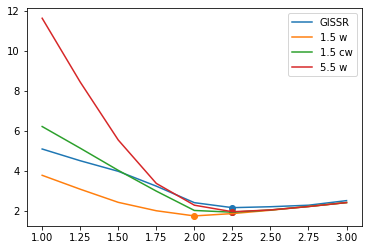

In [12]:
models = [total_cost_GISSR,total_cost_geo_2099_w_1p5,total_cost_geo_2099_w_1p5_cGISSR,total_cost_geo_2099_w_5p5]
model_names = ['GISSR','1.5 w', '1.5 cw', '5.5 w']
for i, model in enumerate(models):
    plt.plot(h_range,model,label = model_names[i])
    plt.scatter(h_range[np.argmin(model)],np.min(model))
plt.legend()

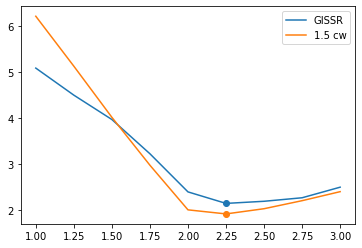

In [15]:
models = [total_cost_GISSR,total_cost_geo_2099_w_1p5_cGISSR]
model_names = ['GISSR', '1.5 cw']
for i, model in enumerate(models):
    plt.plot(h_range,model,label = model_names[i])
    plt.scatter(h_range[np.argmin(model)],np.min(model))
plt.legend()

In [8]:
h_range = np.linspace(0,5,51)
print(h_range)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5. ]


In [10]:
#total_cost_geo_2099_w_1p5_cGISSR = [objective4(h) for h in h_range]

0.0
0
1
2
3
4
5
6
7
8
9
7.2311491130717815
0.1
0
1
2
3
4
5
6
7
8
9
7.219690593992552
0.2
0
1
2
3
4
5
6
7
8
9
7.229221516770926
0.30000000000000004
0
1
2
3
4
5
6
7
8
9
7.2289120126949875
0.4
0
1
2
3
4
5
6
7
8
9
7.154919581353542
0.5
0
1
2
3
4
5
6
7
8
9
7.025285832925514
0.6000000000000001
0
1
2
3
4
5
6
7
8
9
6.935577664181503
0.7000000000000001
0
1
2
3
4
5
6
7
8
9
6.911882762405211
0.8
0
1
2
3
4
5
6
7
8
9
6.707243897682128
0.9
0
1
2
3
4
5
6
7
8
9
6.427787562535615
1.0
0
1
2
3
4
5
6
7
8
9
6.204733421595873
1.1
0
1
2
3
4
5
6
7
8
9
5.900957835240435
1.2000000000000002
0
1
2
3
4
5
6
7
8
9
5.443647888463155
1.3
0
1
2
3
4
5
6
7
8
9
4.823994866915781
1.4000000000000001
0
1
2
3
4
5
6
7
8
9
4.248508091678769
1.5
0
1
2
3
4
5
6
7
8
9
4.016100967606747
1.6
0
1
2
3
4
5
6
7
8
9
3.7826262576153993
1.7000000000000002
0
1
2
3
4
5
6
7
8
9
3.1523134447479775
1.8
0
1
2
3
4
5
6
7
8
9
2.723976194005076
1.9000000000000001
0
1
2
3
4
5
6
7
8
9
2.3583663393824543
2.0
0
1
2
3
4
5
6
7
8
9
2.0125059193943398
2.1
0


In [9]:
#total_cost_GISSR = [objective4(h) for h in h_range]

0.0
0
1
2
3
4
5
6
7
8
9
5.504442646492559
0.1
0
1
2
3
4
5
6
7
8
9
5.508462880812077
0.2
0
1
2
3
4
5
6
7
8
9
5.502596199468482
0.30000000000000004
0
1
2
3
4
5
6
7
8
9
5.452266498949853
0.4
0
1
2
3
4
5
6
7
8
9
5.339022935095087
0.5
0
1
2
3
4
5
6
7
8
9
5.249466877469498
0.6000000000000001
0
1
2
3
4
5
6
7
8
9
5.206047232668506
0.7000000000000001
0
1
2
3
4
5
6
7
8
9
5.202529680465472
0.8
0
1
2
3
4
5
6
7
8
9
5.155703435451742
0.9
0
1
2
3
4
5
6
7
8
9
5.143675920275699
1.0
0
1
2
3
4
5
6
7
8
9
5.082051520996888
1.1
0
1
2
3
4
5
6
7
8
9
4.925469921650156
1.2000000000000002
0
1
2
3
4
5
6
7
8
9
4.652162005694238
1.3
0
1
2
3
4
5
6
7
8
9
4.307128611750549
1.4000000000000001
0
1
2
3
4
5
6
7
8
9
3.953289886769452
1.5
0
1
2
3
4
5
6
7
8
9
3.96849155984592
1.6
0
1
2
3
4
5
6
7
8
9
3.9879026887080142
1.7000000000000002
0
1
2
3
4
5
6
7
8
9
3.4499960592405126
1.8
0
1
2
3
4
5
6
7
8
9
2.928516445993412
1.9000000000000001
0
1
2
3
4
5
6
7
8
9
2.671714060296392
2.0
0
1
2
3
4
5
6
7
8
9
2.401277585205388
2.1
0
1
2
3

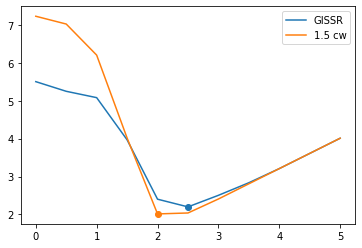

In [7]:
models = [total_cost_GISSR,total_cost_geo_2099_w_1p5_cGISSR]
model_names = ['GISSR', '1.5 cw']
for i, model in enumerate(models):
    plt.plot(h_range,model,label = model_names[i])
    plt.scatter(h_range[np.argmin(model)],np.min(model))
plt.legend()

2.3000000000000003
2.1


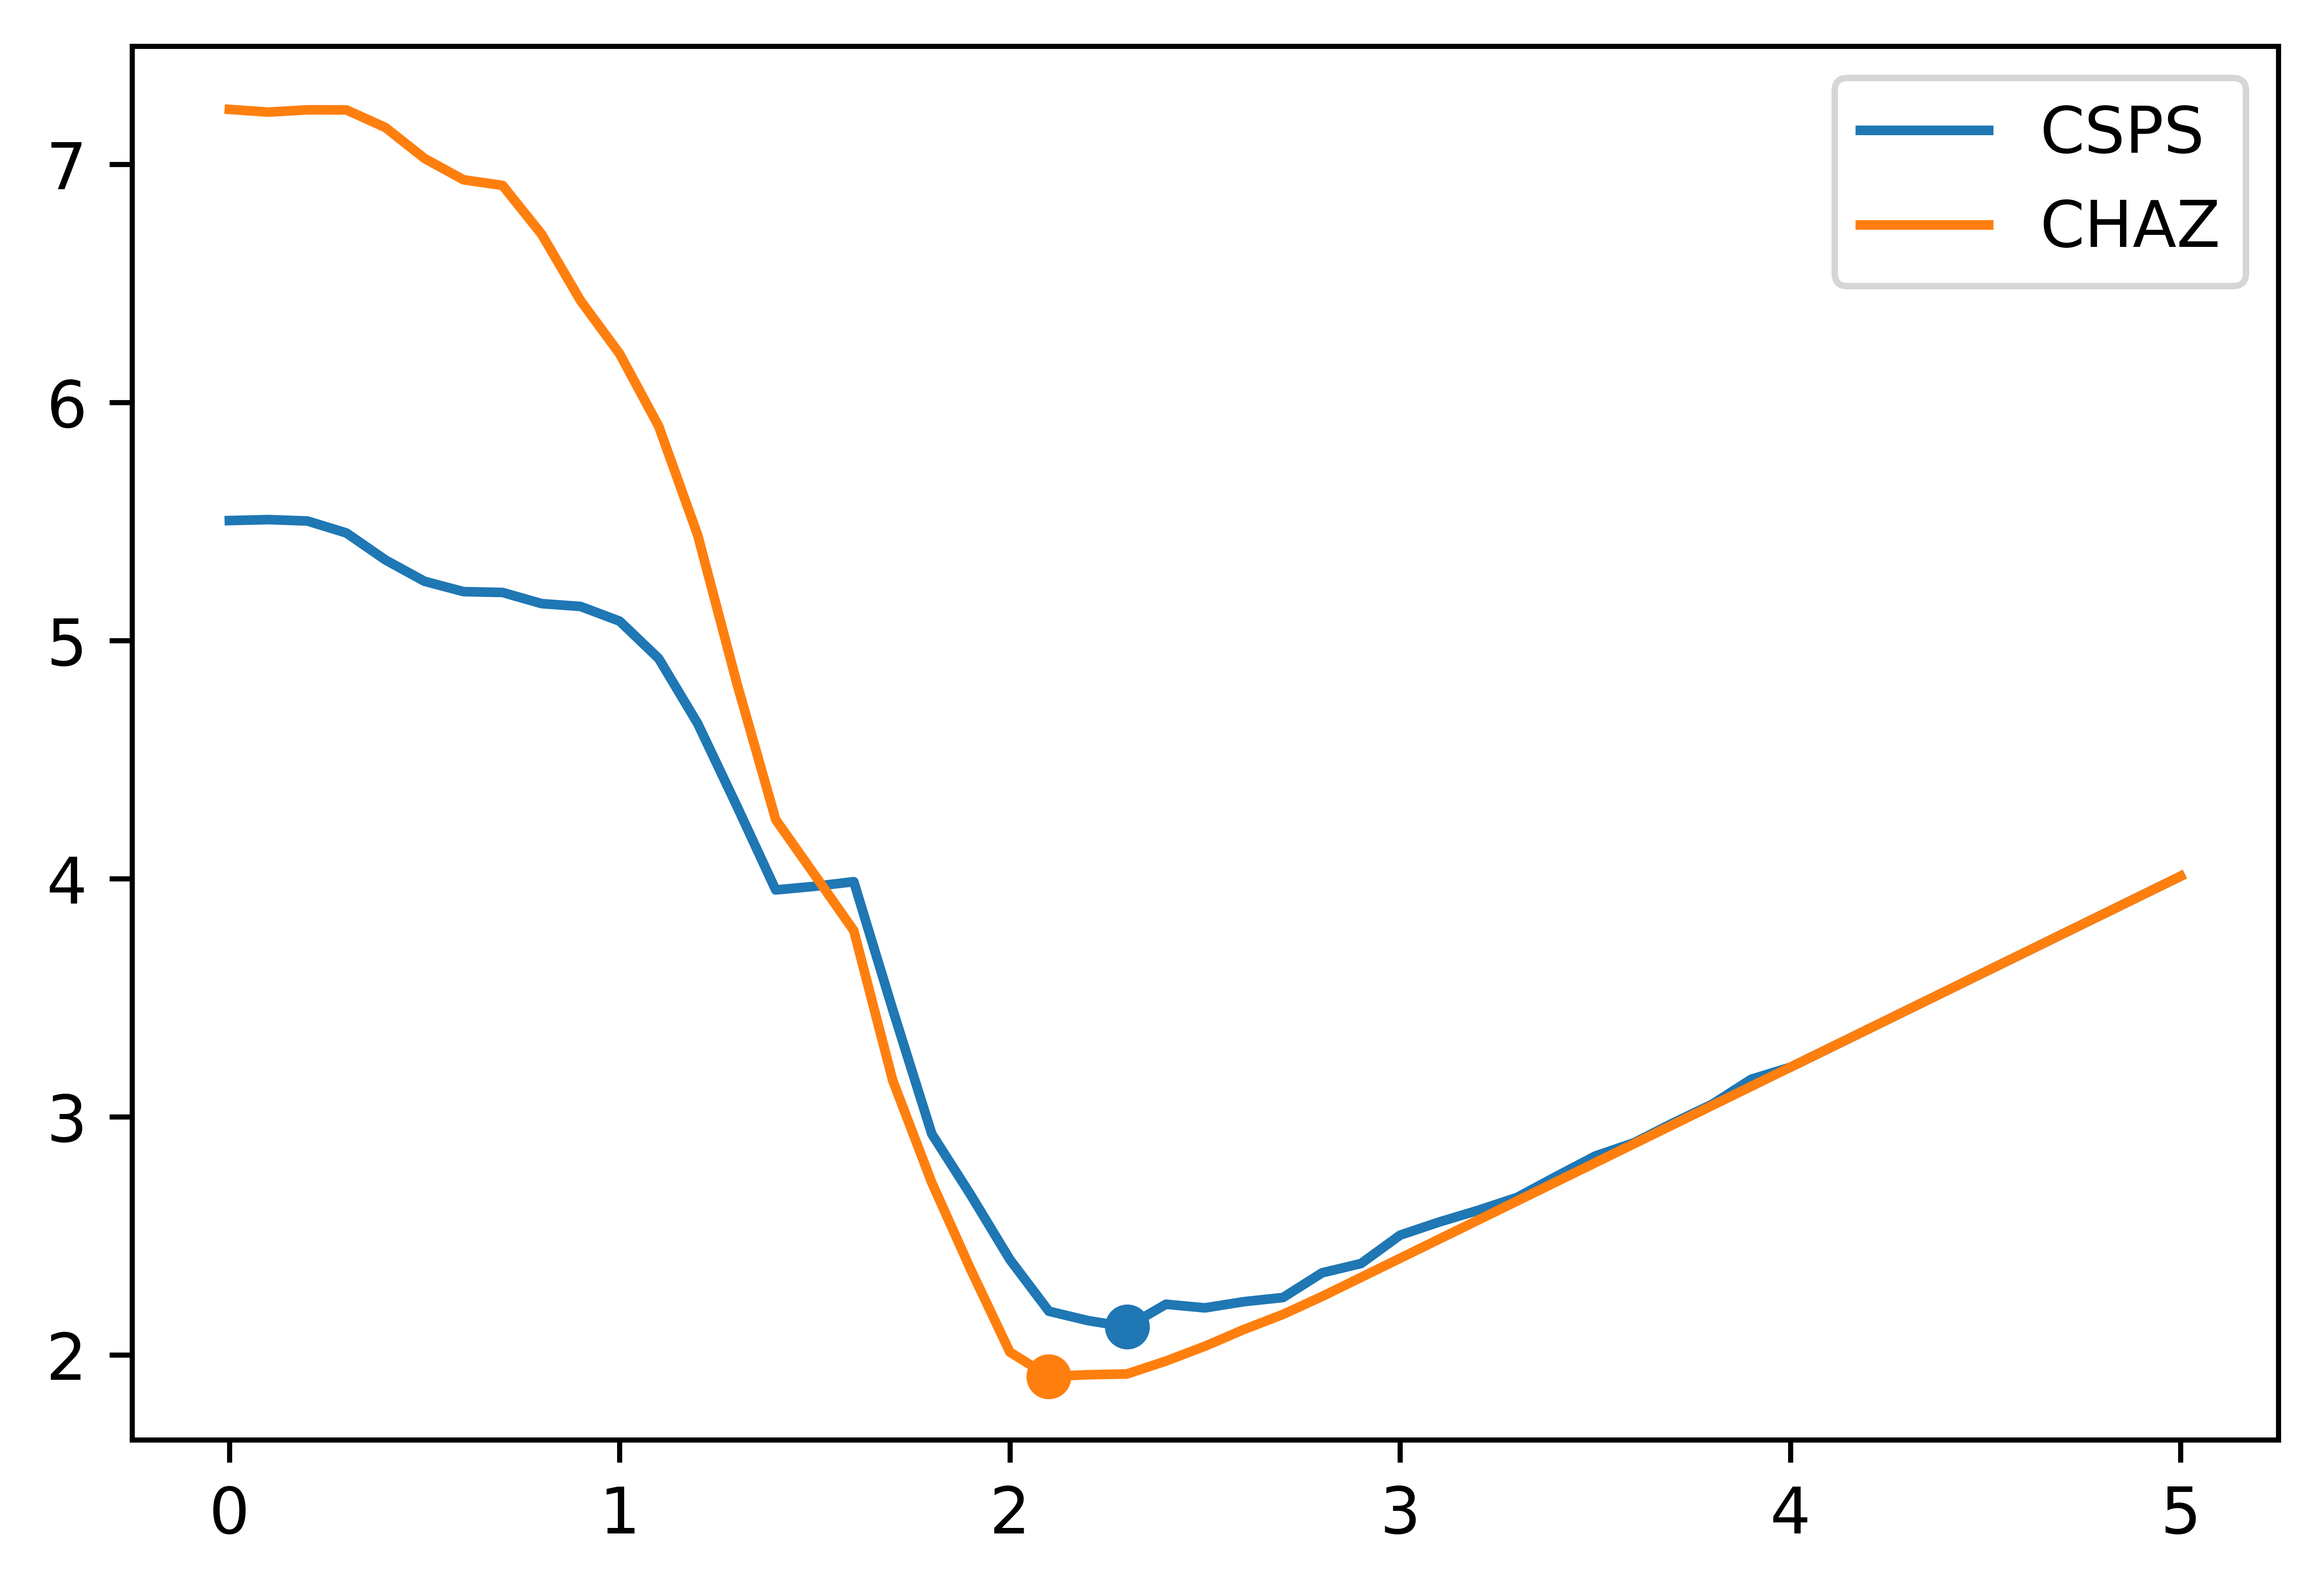

In [18]:
plt.figure(dpi = 1000)
models = [total_cost_GISSR,total_cost_geo_2099_w_1p5_cGISSR]
model_names = ['CSPS', 'CHAZ']
colors = ['tab:blue', 'tab:orange']
for i, model in enumerate(models):
    plt.plot(h_range,model,label = model_names[i], c = colors[i])
    plt.scatter(h_range[np.argmin(model)],np.min(model),c = colors[i])
    #plt.plot([h_range[np.argmin(model)],h_range[np.argmin(model)]],[0,np.min(model)],c = colors[i], ls = '--' )
    print(h_range[np.argmin(model)])
plt.legend()